### SpaotSC

#### Reading Simulated Data

2023-01-30 13:32:42.698091: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 13:32:42.835287: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/mpi/openmpi3-gnu8/3.1.4/lib:/opt/ohpc/pub/compiler/gcc/8.3.0/lib64
2023-01-30 13:32:42.835321: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-30 13:32:43.961536: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinf

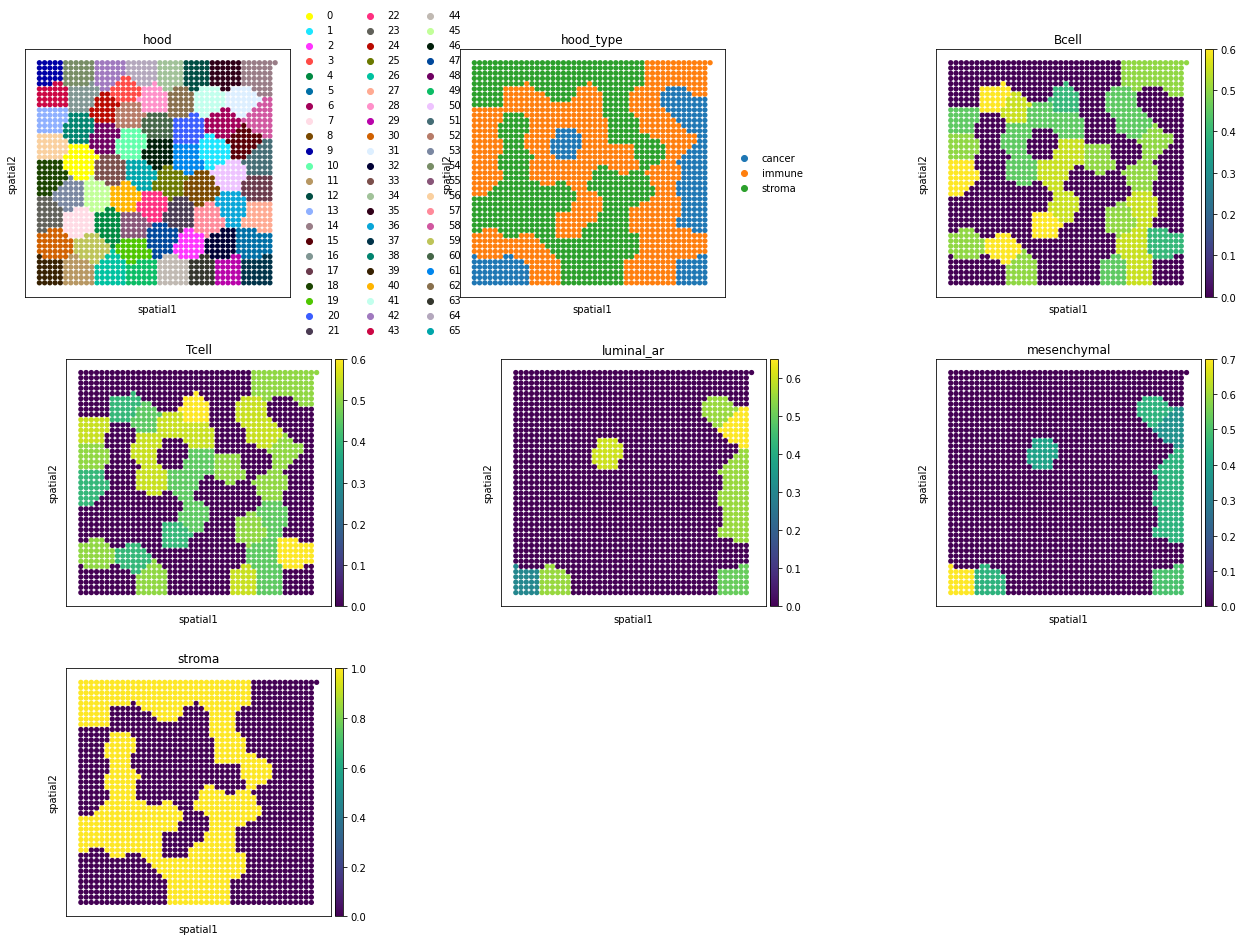

/home/uqomulay/90days/.conda/envs/stlearn_rebuttal_SPA/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/uqomulay/90days/.conda/envs/stlearn_rebuttal_SPA/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


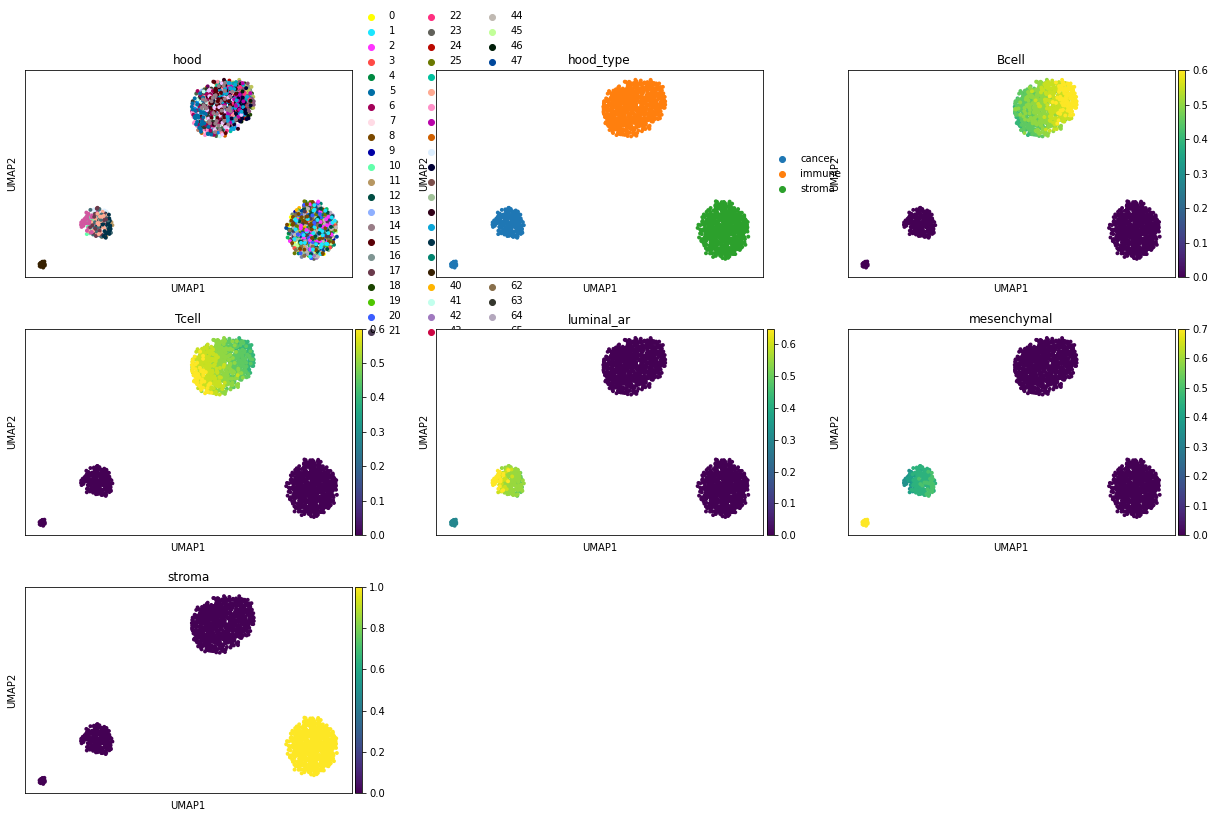

In [1]:
from spaotsc import SpaOTsc
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cluster import KMeans
import ot
import umap
import scanpy as sc
import stlearn as st
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

spatial_data = sc.read_h5ad("/afm01/UQ/Q1851/Brad/simulation/spatialsim_v2.h5ad")
sc.pl.spatial(spatial_data, color=['hood', 'hood_type', 'Bcell', 'Tcell', 'luminal_ar', 'mesenchymal', 'stroma'], ncols=3)
sc.pl.umap(spatial_data, color=['hood', 'hood_type', 'Bcell', 'Tcell', 'luminal_ar', 'mesenchymal', 'stroma'], ncols=3)

#### SpaotSC scores computed for Simulated Data

In [4]:
################################################### Data Reading for SpaotSC ##############################

spatial_data = sc.read_h5ad("/afm01/UQ/Q1851/Brad/simulation/spatialsim_v2.h5ad")
df_is = spatial_data.to_df()
pts = np.array(spatial_data.obs[["imagerow","imagecol"]])
labels = spatial_data.obs["cell_type"]
is_dmat = distance_matrix(pts, pts)
issc = SpaOTsc.spatial_sc(sc_data=np.log(df_is+1))
issc.cell_cell_distance(sc_dmat_spatial=is_dmat)

################################################### LR script -spaotsc ##############################

ligrec_pairs_lib = pd.read_csv("/home/uqomulay/90days/stLearn_rebuttal/SpaTalk/lrpairs.txt", sep="\t")
ligrec_pairs_lib = ligrec_pairs_lib.apply(lambda x: x.astype(str).str.title())
ligrec_pairs_lib = np.array(ligrec_pairs_lib[["Ligand gene symbol","Receptor gene symbol"]])
lower_ligrec_pairs_lib = []
for j in range(0,len(ligrec_pairs_lib.tolist())):
    lower_ligrec_pairs_lib.append([i.upper() for i in ligrec_pairs_lib.tolist()[j]])
lower_ligrec_pairs_lib = np.array(lower_ligrec_pairs_lib)
genes_measured_is = np.array( df_is.columns.values, dtype=str )

ligrec_pairs_is = []
for i in range(len(lower_ligrec_pairs_lib)):
    if lower_ligrec_pairs_lib[i,0] in genes_measured_is and lower_ligrec_pairs_lib[i,1] in genes_measured_is:
        ligrec_pairs_is.append([lower_ligrec_pairs_lib[i,0], lower_ligrec_pairs_lib[i,1]])

ligs = []
for [lig, rec] in ligrec_pairs_is:
    if not lig in ligs:
        ligs.append(lig)
recs = {}
for lig in ligs:
    recs_tmp = []
    for i in range(len(ligrec_pairs_is)):
        if ligrec_pairs_is[i][0] == lig:
            recs_tmp.append(ligrec_pairs_is[i][1])
    recs[lig] = recs_tmp


lig_families = list(np.unique(lower_ligrec_pairs_lib[:,:1]))

lig_family_members = {}
for lig_family in lig_families:
    lig_list_tmp = []
    for lig in ligs:
        if lig[:len(lig_family)] == lig_family:
            lig_list_tmp.append(lig)
    lig_family_members[lig_family] = lig_list_tmp

pts_collection = []
S_collection = []
S_named = {}
cellclusterid = le.fit_transform(labels) #kmeans
n_clusters = len(np.unique(cellclusterid))

for ifield in range(1):
    for lig_family in lig_families:
        S_cell = np.zeros_like(is_dmat)
        for lig in lig_family_members[lig_family]:
            for rec in recs[lig]:
                print("entered")
                if np.max(issc.sc_data[lig]) < 1.0 or np.sum(issc.sc_data[rec], axis=0) < 1.0: continue   
                print("in")
                print(lig,rec)
                S_cell = issc.spatial_signaling_ot([lig], [rec])
                S_cluster_sample = np.zeros([n_clusters,n_clusters], float)
                for clusterA in tuple(np.unique(cellclusterid)):
                    ind_sc_Acl = np.where(cellclusterid==clusterA)[0]
                    for clusterB in tuple(np.unique(cellclusterid)):
                        ind_sc_Bcl = np.where(cellclusterid==clusterB)[0]
                        S_cluster_sample[clusterA,clusterB] = np.mean(S_cell[ind_sc_Acl,:][:,ind_sc_Bcl])
                S_named[lig + '_' + rec] = S_cluster_sample
    pts_collection.append(pts)
    S_collection.append(S_named)
    
    
S_collection_flatten = []

for ifield in range(1):
    S_field = S_collection[ifield]
    S_flatten = {}
    for k,v in S_field.items():
        v = v.flatten()
        S_flatten[k] = v
    S_collection_flatten.append(S_flatten)
for i in range(1):
    csv_to_write = pd.DataFrame.from_dict(S_collection_flatten[i])
    csv_to_write.to_csv("/home/uqomulay/90days/stLearn_rebuttal/SpaOTsc/Simulated_data_SpaotSC_LR_stLearn_clusters.csv")

entered
in
A2M LRP1
entered
in
ACE BDKRB2
entered
in
ADAM10 EPHA3
entered
in
ADAM11 ITGA4
entered
in
ADAM12 ITGA9
entered
in
ADAM12 ITGB1
entered
in
ADAM12 SDC4
entered
in
ADAM15 ITGA5
entered
in
ADAM15 ITGA9
entered
in
ADAM15 ITGAV
entered
in
ADAM15 ITGB1
entered
in
ADAM15 ITGB3
entered
in
ADAM17 ITGA5
entered
in
ADAM17 ITGB1
entered
in
ADAM17 NOTCH1
entered
in
ADAM28 ITGA4
entered
in
ADAM28 ITGA4
entered
in
ADAM9 ITGA3
entered
in
ADAM9 ITGA6
entered
in
ADAM9 ITGAV
entered
in
ADAM9 ITGB1
entered
in
ADAM9 ITGB5
entered
in
ADCYAP1 ADCYAP1R1
entered
in
ADCYAP1 VIPR1
entered
in
ADCYAP1 VIPR2
entered
in
ADIPOQ ADIPOR1
entered
in
ADIPOQ ADIPOR2
entered
in
ADM CALCR
entered
in
ADM CALCRL
entered
in
ADM RAMP2
entered
in
ADM RAMP3
entered
in
ADM2 CALCR
entered
in
ADM2 CALCRL
entered
in
ADM2 RAMP1
entered
in
ADM2 RAMP2
entered
in
ADM2 RAMP3
entered
in
ADM2 CALCR
entered
in
ADM2 CALCRL
entered
in
ADM2 RAMP1
entered
in
ADM2 RAMP2
entered
in
ADM2 RAMP3
entered
in
AGRN DAG1
entered
in
AGRN LRP4
ent

entered
in
CNTF LIFR
entered
in
CNTN1 NOTCH1
entered
in
CNTN1 NOTCH2
entered
in
CNTN1 PTPRZ1
entered
in
CNTN2 CNTN1
entered
in
CNTN2 CNTNAP2
entered
in
CNTN2 NRCAM
entered
in
CNTN4 PTPRG
entered
in
COL11A1 DDR1
entered
in
COL14A1 CD44
entered
in
COL18A1 GPC1
entered
in
COL18A1 GPC4
entered
in
COL18A1 ITGA5
entered
in
COL18A1 ITGB1
entered
in
COL18A1 KDR
entered
in
COL18A1 PTPRS
entered
in
COL1A1 CD36
entered
in
COL1A1 CD44
entered
in
COL1A1 CD93
entered
in
COL1A1 DDR1
entered
in
COL1A1 DDR2
entered
in
COL1A1 GP6
entered
in
COL1A1 ITGA11
entered
in
COL1A1 ITGA2
entered
in
COL1A1 ITGA5
entered
in
COL1A1 ITGB1
entered
in
COL1A2 CD44
entered
in
COL1A2 CD93
entered
in
COL1A2 GP6
entered
in
COL1A2 ITGA11
entered
in
COL1A2 ITGA2
entered
in
COL1A2 ITGB1
entered
in
COL1A2 ITGB3
entered
in
COL2A1 DDR1
entered
in
COL2A1 ITGA10
entered
in
COL2A1 ITGA2
entered
in
COL2A1 ITGB1
entered
in
COL2A1 TNFRSF10A
entered
in
COL3A1 DDR1
entered
in
COL3A1 DDR2
entered
in
COL4A1 CD93
entered
in
COL4A1 ITGA1
ent

entered
in
GDF11 ACVR2B
entered
in
GDF15 GFRAL
entered
in
GDF5 ACVR1
entered
in
GDF5 ACVR2A
entered
in
GDF5 ACVR2B
entered
in
GDF5 BMPR1A
entered
in
GDF5 BMPR1B
entered
in
GDF5 BMPR2
entered
in
GDF5 ROR2
entered
in
GDF6 BMPR1A
entered
in
GDF6 BMPR1B
entered
in
GDF6 BMPR2
entered
in
GDNF GFRA1
entered
in
GDNF GFRA2
entered
in
GDNF RET
entered
in
GHRL GHSR
entered
in
GHRL GPR39
entered
in
GLG1 SELE
entered
in
GNAI2 ADCY1
entered
in
GNAI2 ADORA1
entered
in
GNAI2 ADRA2A
entered
in
GNAI2 ADRA2B
entered
in
GNAI2 C5AR1
entered
in
GNAI2 CAV1
entered
in
GNAI2 CCR5
entered
in
GNAI2 CNR1
entered
in
GNAI2 CXCR2
entered
in
GNAI2 EDNRA
entered
in
GNAI2 EGFR
entered
in
GNAI2 F2R
entered
in
GNAI2 FPR1
entered
in
GNAI2 IGF1R
entered
in
GNAI2 LPAR3
entered
in
GNAI2 OPRM1
entered
in
GNAI2 TBXA2R
entered
in
GNAI2 TSHR
entered
in
GNAS ADRB2
entered
entered
in
GNAS CRHR1
entered
in
GNAS PTGDR
entered
in
GNAS TSHR
entered
in
GNAS VIPR1
entered
in
GNRH1 GNRHR
entered
in
GPC3 CD81
entered
in
GPC3 IGF1R
entered

entered
in
MST1 MST1R
entered
in
MSTN ACVR2B
entered
in
MUC1 SIGLEC9
entered
in
MUC2 AGR2
entered
in
MYL9 CD69
entered
in
MYOC FZD1
entered
in
MYOC FZD10
entered
in
MYOC FZD3
entered
in
MYOC FZD4
entered
in
MYOC FZD7
entered
in
NAMPT INSR
entered
in
NCAM1 FGFR1
entered
in
NCAM1 GFRA1
entered
in
NCAM1 PTPRZ1
entered
in
NCAM1 ROBO1
entered
in
NCAM1 ROBO3
entered
in
NDP FZD4
entered
in
NDP LGR4
entered
in
NELL2 ROBO3
entered
in
NGF NGFR
entered
in
NGF NTRK1
entered
in
NGF SORT1
entered
in
NID1 COL13A1
entered
in
NID1 ITGAV
entered
in
NID1 ITGB3
entered
in
NID1 PTPRF
entered
in
NID2 COL13A1
entered
in
NLGN1 NRXN1
entered
in
NLGN1 NRXN2
entered
in
NLGN1 NRXN3
entered
in
NLGN2 NRXN1
entered
in
NLGN2 NRXN2
entered
in
NLGN2 NRXN3
entered
in
NLGN3 NRXN1
entered
in
NLGN3 NRXN2
entered
in
NLGN3 NRXN3
entered
in
NLGN4X NRXN1
entered
in
NMB GRPR
entered
in
NMB NMBR
entered
in
NMU NMUR1
entered
in
NODAL ACVR1B
entered
in
NODAL ACVR1C
entered
in
NODAL ACVR2A
entered
in
NODAL ACVR2B
entered
in
NODAL T

entered
in
TGFB1 SDC2
entered
in
TGFB1 TGFBR1
entered
in
TGFB1 TGFBR2
entered
in
TGFB1 TGFBR3
entered
in
TGFB1 VASN
entered
in
TGFB2 ACVR1
entered
in
TGFB2 ENG
entered
in
TGFB2 TGFBR1
entered
in
TGFB2 TGFBR2
entered
in
TGFB2 TGFBR3
entered
in
TGFB3 ACVRL1
entered
in
TGFB3 ENG
entered
in
TGFB3 TGFBR1
entered
in
TGFB3 TGFBR2
entered
in
TGFB3 TGFBR3
entered
in
TGM2 ITGB1
entered
in
TGM2 ITGB3
entered
in
TGM2 SDC4
entered
in
TGFA EGFR
entered
in
TGFA ERBB2
entered
in
TGFA ERBB4
entered
in
TGFB1 ACVRL1
entered
in
TGFB1 ENG
entered
in
TGFB1 ITGAV
entered
in
TGFB1 ITGB6
entered
in
TGFB1 ITGB8
entered
in
TGFB1 SDC2
entered
in
TGFB1 TGFBR1
entered
in
TGFB1 TGFBR2
entered
in
TGFB1 TGFBR3
entered
in
TGFB1 VASN
entered
in
TGFB2 ACVR1
entered
in
TGFB2 ENG
entered
in
TGFB2 TGFBR1
entered
in
TGFB2 TGFBR2
entered
in
TGFB2 TGFBR3
entered
in
TGFB3 ACVRL1
entered
in
TGFB3 ENG
entered
in
TGFB3 TGFBR1
entered
in
TGFB3 TGFBR2
entered
in
TGFB3 TGFBR3
entered
in
TGM2 ITGB1
entered
in
TGM2 ITGB3
entered
in
TGM

In [6]:
le.inverse_transform([0, 1, 2, 3, 4])

array(['Bcell', 'Tcell', 'luminal_ar', 'mesenchymal', 'stroma'],
      dtype=object)

#### Reading Breast Cancer Data

In [1]:
from spaotsc import SpaOTsc
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cluster import KMeans
import ot
import umap
import scanpy as sc
import stlearn as st
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

data_dir = "/afm01/UQ/Q1851/Jon/Human_Breast_Cancer_Block_A_Section_1/"
spatial_data = st.Read10X(data_dir)
spatial_data.var_names_make_unique()
st.add.image(adata=spatial_data,
             imgpath=data_dir+"spatial/tissue_hires_nobg.png",
             library_id="V1_Breast_Cancer_Block_A_Section_1", visium=True)

label_transfer = pd.read_csv("/home/uqomulay/90days/stLearn_rebuttal/block1/label_transfer_bc.csv",sep="\t")
print(np.all(label_transfer.index.values==spatial_data.obs_names.values))

2023-01-30 13:54:10.675383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 13:54:10.807664: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/mpi/openmpi3-gnu8/3.1.4/lib:/opt/ohpc/pub/compiler/gcc/8.3.0/lib64
2023-01-30 13:54:10.807697: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-30 13:54:11.876701: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinf

Added tissue image to the object!
True


#### SpaotSC scores computed for Breast Cancer Data - The clusters here are label transfer clusters 

In [2]:
################################################### Data Reading ##############################

#spatial_data = sc.read_h5ad("/afm01/UQ/Q1851/Brad/simulation/spatialsim_v2.h5ad")
df_is = spatial_data.to_df()
pts = np.array(spatial_data.obs[["array_row","array_col"]])
labels = label_transfer["predicted.id"]
is_dmat = distance_matrix(pts, pts)
issc = SpaOTsc.spatial_sc(sc_data=np.log(df_is+1))
issc.cell_cell_distance(sc_dmat_spatial=is_dmat)
#issc.sc_data = issc.is_data

################################################### LR script -spaotsc ##############################
 
ligrec_pairs_lib = pd.read_csv("/home/uqomulay/90days/stLearn_rebuttal/SpaTalk/lrpairs.txt", sep="\t")
ligrec_pairs_lib = ligrec_pairs_lib.apply(lambda x: x.astype(str).str.title())
ligrec_pairs_lib = np.array(ligrec_pairs_lib[["Ligand gene symbol","Receptor gene symbol"]])
lower_ligrec_pairs_lib = []
for j in range(0,len(ligrec_pairs_lib.tolist())):
    lower_ligrec_pairs_lib.append([i.upper() for i in ligrec_pairs_lib.tolist()[j]])
lower_ligrec_pairs_lib = np.array(lower_ligrec_pairs_lib)
genes_measured_is = np.array( df_is.columns.values, dtype=str )

ligrec_pairs_is = []
for i in range(len(lower_ligrec_pairs_lib)):
    if lower_ligrec_pairs_lib[i,0] in genes_measured_is and lower_ligrec_pairs_lib[i,1] in genes_measured_is:
        ligrec_pairs_is.append([lower_ligrec_pairs_lib[i,0], lower_ligrec_pairs_lib[i,1]])

ligs = []
for [lig, rec] in ligrec_pairs_is:
    if not lig in ligs:
        ligs.append(lig)
recs = {}
for lig in ligs:
    recs_tmp = []
    for i in range(len(ligrec_pairs_is)):
        if ligrec_pairs_is[i][0] == lig:
            recs_tmp.append(ligrec_pairs_is[i][1])
    recs[lig] = recs_tmp


lig_families = list(np.unique(lower_ligrec_pairs_lib[:,:1]))

lig_family_members = {}
for lig_family in lig_families:
    lig_list_tmp = []
    for lig in ligs:
        if lig[:len(lig_family)] == lig_family:
            lig_list_tmp.append(lig)
    lig_family_members[lig_family] = lig_list_tmp

pts_collection = []
S_collection = []
S_named = {}
cellclusterid = le.fit_transform(labels) #kmeans
n_clusters = len(np.unique(cellclusterid))

for ifield in range(1):
    for lig_family in lig_families:
        S_cell = np.zeros_like(is_dmat)
        for lig in lig_family_members[lig_family]:
            for rec in recs[lig]:
                print("entered")
                if np.max(issc.sc_data[lig]) < 1.0 or np.sum(issc.sc_data[rec], axis=0) < 1.0: continue   
                print("in")
                print(lig,rec)
                S_cell = issc.spatial_signaling_ot([lig], [rec])
                S_cluster_sample = np.zeros([n_clusters,n_clusters], float)
                for clusterA in tuple(np.unique(cellclusterid)):
                    ind_sc_Acl = np.where(cellclusterid==clusterA)[0]
                    for clusterB in tuple(np.unique(cellclusterid)):
                        ind_sc_Bcl = np.where(cellclusterid==clusterB)[0]
                        S_cluster_sample[clusterA,clusterB] = np.mean(S_cell[ind_sc_Acl,:][:,ind_sc_Bcl])
                S_named[lig + '_' + rec] = S_cluster_sample
    pts_collection.append(pts)
    S_collection.append(S_named)
    
    
S_collection_flatten = []

for ifield in range(1):
    S_field = S_collection[ifield]
    S_flatten = {}
    for k,v in S_field.items():
        v = v.flatten()
        S_flatten[k] = v
    S_collection_flatten.append(S_flatten)
for i in range(1):
    csv_to_write = pd.DataFrame.from_dict(S_collection_flatten[i])
    csv_to_write.to_csv("/home/uqomulay/90days/stLearn_rebuttal/SpaOTsc/BC_SpaotSC_LR_stLearn_clusters.csv")

entered
in
A2M LRP1
entered
entered
entered
in
ACE BDKRB2
entered
in
ADAM10 EPHA3
entered
in
ADAM11 ITGA4
entered
in
ADAM12 ITGA9
entered
in
ADAM12 ITGB1
entered
in
ADAM12 SDC4
entered
in
ADAM15 ITGA5
entered
in
ADAM15 ITGA9
entered
in
ADAM15 ITGAV
entered
in
ADAM15 ITGB1
entered
in
ADAM15 ITGB3
entered
in
ADAM17 ITGA5
entered
in
ADAM17 ITGB1
entered
in
ADAM17 NOTCH1
entered
entered
entered
entered
entered
in
ADAM23 ITGA4
entered
in
ADAM23 ITGA5
entered
in
ADAM23 ITGB3
entered
in
ADAM28 ITGA4
entered
entered
in
ADAM23 ITGA4
entered
in
ADAM23 ITGA5
entered
in
ADAM23 ITGB3
entered
in
ADAM28 ITGA4
entered
entered
entered
entered
in
ADAM9 ITGA3
entered
in
ADAM9 ITGA6
entered
in
ADAM9 ITGAV
entered
in
ADAM9 ITGB1
entered
in
ADAM9 ITGB5
entered
entered
entered
entered
entered
in
ADGRB1 RTN4R
entered
in
ADGRB1 RTN4RL1
entered
in
ADGRB1 RTN4RL2
entered
in
ADGRE5 CD55
entered
in
ADIPOQ ADIPOR1
entered
in
ADIPOQ ADIPOR2
entered
in
ADM CALCR
entered
in
ADM CALCRL
entered
entered
in
ADM RAMP2
ente

entered
in
CCL3L1 CCR5
entered
in
CCL3L1 ACKR2
entered
in
CCL3L1 CCR1
entered
in
CCL3L1 CCR3
entered
in
CCL3L1 CCR5
entered
in
CCL4 ACKR2
entered
in
CCL4 CCR1
entered
in
CCL4 CCR3
entered
in
CCL4 CCR5
entered
in
CCL4 CCR8
entered
in
CCL5 ACKR1
entered
in
CCL5 ACKR2
entered
in
CCL5 CCR1
entered
in
CCL5 CCR3
entered
in
CCL5 CCR4
entered
in
CCL5 CCR5
entered
in
CCL5 CXCR3
entered
in
CCL5 GPR75
entered
in
CCL5 SDC1
entered
in
CCL5 SDC4
entered
in
CCL7 ACKR1
entered
in
CCL7 ACKR2
entered
in
CCL7 ACKR4
entered
in
CCL7 CCR1
entered
in
CCL7 CCR10
entered
in
CCL7 CCR2
entered
in
CCL7 CCR3
entered
in
CCL7 CCR5
entered
in
CCL7 CXCR3
entered
in
CCL8 ACKR1
entered
in
CCL8 ACKR2
entered
in
CCL8 ACKR4
entered
in
CCL8 CCR1
entered
in
CCL8 CCR2
entered
in
CCL8 CCR3
entered
in
CCL8 CCR5
entered
in
CD14 ITGA4
entered
in
CD14 ITGB1
entered
entered
in
CD177 PECAM1
entered
in
CD1D LILRB2
entered
in
CD2 CD48
entered
in
CD200 CD200R1
entered
entered
in
CD200R1 CD200
entered
in
CD209 ICAM3
entered
in
CD22 PTPR

entered
in
EFNA4 EPHA2
entered
in
EFNA4 EPHA3
entered
in
EFNA4 EPHA4
entered
in
EFNA4 EPHA5
entered
in
EFNA4 EPHA6
entered
in
EFNA4 EPHA7
entered
in
EFNA4 EPHA8
entered
in
EFNA5 EPHA1
entered
in
EFNA5 EPHA2
entered
in
EFNA5 EPHA3
entered
in
EFNA5 EPHA4
entered
in
EFNA5 EPHA5
entered
in
EFNA5 EPHA6
entered
in
EFNA5 EPHA7
entered
in
EFNA5 EPHA8
entered
in
EFNA5 EPHB1
entered
in
EFNA5 EPHB2
entered
in
EFNA5 EPHB6
entered
in
EFNB1 EPHA4
entered
in
EFNB1 EPHB1
entered
in
EFNB1 EPHB2
entered
in
EFNB1 EPHB3
entered
in
EFNB1 EPHB4
entered
in
EFNB1 EPHB6
entered
in
EFNB1 ERBB2
entered
in
EFNB2 EPHA3
entered
in
EFNB2 EPHA4
entered
in
EFNB2 EPHA6
entered
in
EFNB2 EPHB1
entered
in
EFNB2 EPHB2
entered
in
EFNB2 EPHB3
entered
in
EFNB2 EPHB4
entered
in
EFNB2 EPHB6
entered
in
EFNB2 GRM1
entered
entered
in
EFNB2 PECAM1
entered
in
EFNB2 RHBDL2
entered
in
EFNB3 EPHA4
entered
in
EFNB3 EPHB1
entered
in
EFNB3 EPHB2
entered
in
EFNB3 EPHB3
entered
in
EFNB3 EPHB4
entered
in
EFNB3 EPHB6
entered
in
EFNB3 RHBDL2
e

entered
entered
entered
entered
entered
entered
entered
entered
entered
entered
entered
entered
entered
entered
entered
in
IFNG IFNGR1
entered
in
IFNG IFNGR2
entered
entered
entered
in
IFNL1 IFNLR1
entered
in
IFNL1 IL10RB
entered
in
IFNL2 IFNLR1
entered
in
IFNL2 IL10RB
entered
in
IFNL3 IFNLR1
entered
in
IFNL3 IL10RB
entered
entered
entered
in
IGF1 IGF1R
entered
entered
entered
entered
in
IGFBP4 FZD8
entered
in
IGFBP4 LRP6
entered
in
IGFL1 IGFLR1
entered
in
IGFL2 IGFLR1
entered
in
IGFL3 IGFLR1
entered
entered
entered
entered
entered
entered
entered
in
IL10 IL10RA
entered
in
IL10 IL10RB
entered
entered
entered
in
IL12A IL12RB1
entered
in
IL12A IL12RB2
entered
entered
entered
entered
entered
entered
entered
entered
in
IL15 IL15RA
entered
in
IL15 IL2RA
entered
in
IL15 IL2RB
entered
in
IL15 IL2RG
entered
in
IL16 CD4
entered
in
IL16 GRIN2D
entered
in
IL16 KCNJ10
entered
in
IL16 KCNJ15
entered
entered
entered
entered
in
IL17C IL17RA
entered
in
IL17C IL17RE
entered
in
IL17F IL17RA
entered
in
I

entered
in
NXPH1 NRXN3
entered
entered
entered
in
NXPH3 NRXN2
entered
in
NXPH3 NRXN3
entered
entered
entered
entered
entered
in
ORM1 CCR5
entered
in
OSM IL6ST
entered
in
OSM LIFR
entered
in
OSM OSMR
entered
entered
entered
entered
entered
entered
entered
entered
in
PDCD1LG2 PDCD1
entered
in
PDCD1LG2 RGMB
entered
in
PDGFA PDGFRA
entered
entered
in
PDGFB LRP1
entered
in
PDGFB PDGFRA
entered
in
PDGFB PDGFRB
entered
in
PDGFC PDGFRA
entered
in
PDGFC PDGFRB
entered
in
PDGFD PDGFRB
entered
entered
entered
entered
entered
in
PECAM1 CD38
entered
entered
entered
entered
entered
entered
entered
entered
entered
entered
entered
entered
entered
in
PGF FLT1
entered
in
PGF NRP1
entered
in
PGF NRP2
entered
entered
in
PIP CD4
entered
in
PLA2G10 PLA2R1
entered
in
PLA2G2A ITGA4
entered
in
PLA2G2A ITGA5
entered
in
PLA2G2A ITGAV
entered
in
PLA2G2A ITGB1
entered
in
PLA2G2A ITGB3
entered
in
PLAT LRP1
entered
in
PLAU IGF2R
entered
in
PLAU LRP1
entered
in
PLAU LRP2
entered
in
PLAU PLAUR
entered
in
PLAU ST14
ent

entered
in
THBS1 ITGA4
entered
in
THBS1 ITGA6
entered
in
THBS1 ITGB1
entered
in
THBS1 ITGB3
entered
in
THBS1 LRP1
entered
in
THBS1 PTPRJ
entered
in
THBS1 SDC1
entered
in
THBS1 SDC4
entered
in
THBS1 TNFRSF11B
entered
in
THBS2 CD47
entered
in
THBS2 ITGA4
entered
in
THBS2 ITGA6
entered
in
THBS2 ITGB1
entered
in
THBS2 NOTCH3
entered
entered
in
TIGIT NECTIN2
entered
in
TIGIT PVR
entered
entered
in
TIMP1 CD63
entered
in
TIMP2 ITGA3
entered
in
TIMP2 ITGB1
entered
entered
in
TIMP3 KDR
entered
in
TNC CNTN1
entered
in
TNC EGFR
entered
in
TNC ITGA7
entered
in
TNC ITGAV
entered
in
TNC ITGB1
entered
in
TNC ITGB3
entered
in
TNC PTPRB
entered
entered
in
TNF TNFRSF1A
entered
in
TNF TNFRSF1B
entered
in
TNF TNFRSF21
entered
in
TNFRSF14 BTLA
entered
in
TNFRSF14 CD160
entered
in
TNFSF10 TNFRSF10A
entered
in
TNFSF10 TNFRSF10B
entered
in
TNFSF10 TNFRSF10C
entered
in
TNFSF10 TNFRSF10D
entered
in
TNFSF10 TNFRSF11B
entered
in
TNFSF11 TNFRSF11A
entered
in
TNFSF11 TNFRSF11B
entered
in
TNFSF12 CD163
entered
in
TN

In [3]:
le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8])

array(['Bcell', 'Tcell', 'basal_like_1', 'basal_like_2', 'endothelial',
       'luminal_ar', 'macrophage', 'mesenchymal', 'stroma'], dtype=object)

#### Reading Breast Cancer Data - Louvian Cluster

In [1]:
from spaotsc import SpaOTsc
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cluster import KMeans
import ot
import umap
import scanpy as sc
import stlearn as st
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

data_dir = "/afm01/UQ/Q1851/Jon/Human_Breast_Cancer_Block_A_Section_1/"
spatial_data = st.Read10X(data_dir)
spatial_data.var_names_make_unique()
st.add.image(adata=spatial_data,
             imgpath=data_dir+"spatial/tissue_hires_nobg.png",
             library_id="V1_Breast_Cancer_Block_A_Section_1", visium=True)

label_transfer = pd.read_csv("/home/uqomulay/90days/stLearn_rebuttal/bc_leiden_cluster.csv", index_col=0)
spatial_data = spatial_data[spatial_data.obs.index.isin(label_transfer.index)]
print(np.all(label_transfer.index.values==spatial_data.obs_names.values))

2023-01-30 20:31:42.170812: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 20:31:42.308696: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/mpi/openmpi3-gnu8/3.1.4/lib:/opt/ohpc/pub/compiler/gcc/8.3.0/lib64
2023-01-30 20:31:42.308727: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-30 20:31:43.418675: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinf

Added tissue image to the object!
True


#### SpaotSC scores computed for Breast Cancer Data - The clusters here are louvain clusters

In [4]:
################################################### Data Reading ##############################

#spatial_data = sc.read_h5ad("/afm01/UQ/Q1851/Brad/simulation/spatialsim_v2.h5ad")
df_is = spatial_data.to_df()
pts = np.array(spatial_data.obs[["array_row","array_col"]])
labels = label_transfer["cell_type"]
is_dmat = distance_matrix(pts, pts)
issc = SpaOTsc.spatial_sc(sc_data=np.log(df_is+1))
issc.cell_cell_distance(sc_dmat_spatial=is_dmat)
#issc.sc_data = issc.is_data

################################################### LR script -spaotsc ##############################
 
ligrec_pairs_lib = pd.read_csv("/home/uqomulay/90days/stLearn_rebuttal/SpaTalk/lrpairs.txt", sep="\t")
ligrec_pairs_lib = ligrec_pairs_lib.apply(lambda x: x.astype(str).str.title())
ligrec_pairs_lib = np.array(ligrec_pairs_lib[["Ligand gene symbol","Receptor gene symbol"]])
lower_ligrec_pairs_lib = []
for j in range(0,len(ligrec_pairs_lib.tolist())):
    lower_ligrec_pairs_lib.append([i.upper() for i in ligrec_pairs_lib.tolist()[j]])
lower_ligrec_pairs_lib = np.array(lower_ligrec_pairs_lib)
genes_measured_is = np.array( df_is.columns.values, dtype=str )

ligrec_pairs_is = []
for i in range(len(lower_ligrec_pairs_lib)):
    if lower_ligrec_pairs_lib[i,0] in genes_measured_is and lower_ligrec_pairs_lib[i,1] in genes_measured_is:
        ligrec_pairs_is.append([lower_ligrec_pairs_lib[i,0], lower_ligrec_pairs_lib[i,1]])

ligs = []
for [lig, rec] in ligrec_pairs_is:
    if not lig in ligs:
        ligs.append(lig)
recs = {}
for lig in ligs:
    recs_tmp = []
    for i in range(len(ligrec_pairs_is)):
        if ligrec_pairs_is[i][0] == lig:
            recs_tmp.append(ligrec_pairs_is[i][1])
    recs[lig] = recs_tmp


lig_families = list(np.unique(lower_ligrec_pairs_lib[:,:1]))

lig_family_members = {}
for lig_family in lig_families:
    lig_list_tmp = []
    for lig in ligs:
        if lig[:len(lig_family)] == lig_family:
            lig_list_tmp.append(lig)
    lig_family_members[lig_family] = lig_list_tmp

pts_collection = []
S_collection = []
S_named = {}
cellclusterid = le.fit_transform(labels) #kmeans
n_clusters = len(np.unique(cellclusterid))

for ifield in range(1):
    for lig_family in lig_families:
        S_cell = np.zeros_like(is_dmat)
        for lig in lig_family_members[lig_family]:
            for rec in recs[lig]:
                print("entered")
                if np.max(issc.sc_data[lig]) < 1.0 or np.sum(issc.sc_data[rec], axis=0) < 1.0: continue   
                print("in")
                print(lig,rec)
                S_cell = issc.spatial_signaling_ot([lig], [rec])
                S_cluster_sample = np.zeros([n_clusters,n_clusters], float)
                for clusterA in tuple(np.unique(cellclusterid)):
                    ind_sc_Acl = np.where(cellclusterid==clusterA)[0]
                    for clusterB in tuple(np.unique(cellclusterid)):
                        ind_sc_Bcl = np.where(cellclusterid==clusterB)[0]
                        S_cluster_sample[clusterA,clusterB] = np.mean(S_cell[ind_sc_Acl,:][:,ind_sc_Bcl])
                S_named[lig + '_' + rec] = S_cluster_sample
    pts_collection.append(pts)
    S_collection.append(S_named)
    
    
S_collection_flatten = []

for ifield in range(1):
    S_field = S_collection[ifield]
    S_flatten = {}
    for k,v in S_field.items():
        v = v.flatten()
        S_flatten[k] = v
    S_collection_flatten.append(S_flatten)
for i in range(1):
    csv_to_write = pd.DataFrame.from_dict(S_collection_flatten[i])
    csv_to_write.to_csv("/home/uqomulay/90days/stLearn_rebuttal/SpaOTsc/BC_SpaotSC_LR_stLearn_lieden_clusters.csv")

entered
in
A2M LRP1
entered
entered
entered
in
ACE BDKRB2
entered
in
ADAM10 EPHA3
entered
in
ADAM11 ITGA4
entered
in
ADAM12 ITGA9
entered
in
ADAM12 ITGB1
entered
in
ADAM12 SDC4
entered
in
ADAM15 ITGA5
entered
in
ADAM15 ITGA9
entered
in
ADAM15 ITGAV
entered
in
ADAM15 ITGB1
entered
in
ADAM15 ITGB3
entered
in
ADAM17 ITGA5
entered
in
ADAM17 ITGB1
entered
in
ADAM17 NOTCH1
entered
entered
entered
entered
entered
in
ADAM23 ITGA4
entered
in
ADAM23 ITGA5
entered
in
ADAM23 ITGB3
entered
in
ADAM28 ITGA4
entered
entered
in
ADAM23 ITGA4
entered
in
ADAM23 ITGA5
entered
in
ADAM23 ITGB3
entered
in
ADAM28 ITGA4
entered
entered
entered
entered
in
ADAM9 ITGA3
entered
in
ADAM9 ITGA6
entered
in
ADAM9 ITGAV
entered
in
ADAM9 ITGB1
entered
in
ADAM9 ITGB5
entered
entered
entered
entered
entered
in
ADGRB1 RTN4R
entered
in
ADGRB1 RTN4RL1
entered
in
ADGRB1 RTN4RL2
entered
in
ADGRE5 CD55
entered
in
ADIPOQ ADIPOR1
entered
in
ADIPOQ ADIPOR2
entered
in
ADM CALCR
entered
in
ADM CALCRL
entered
entered
in
ADM RAMP2
ente

entered
in
CCL3L1 CCR5
entered
in
CCL3L1 ACKR2
entered
in
CCL3L1 CCR1
entered
in
CCL3L1 CCR3
entered
in
CCL3L1 CCR5
entered
in
CCL4 ACKR2
entered
in
CCL4 CCR1
entered
in
CCL4 CCR3
entered
in
CCL4 CCR5
entered
in
CCL4 CCR8
entered
in
CCL5 ACKR1
entered
in
CCL5 ACKR2
entered
in
CCL5 CCR1
entered
in
CCL5 CCR3
entered
in
CCL5 CCR4
entered
in
CCL5 CCR5
entered
in
CCL5 CXCR3
entered
in
CCL5 GPR75
entered
in
CCL5 SDC1
entered
in
CCL5 SDC4
entered
in
CCL7 ACKR1
entered
in
CCL7 ACKR2
entered
in
CCL7 ACKR4
entered
in
CCL7 CCR1
entered
in
CCL7 CCR10
entered
in
CCL7 CCR2
entered
in
CCL7 CCR3
entered
in
CCL7 CCR5
entered
in
CCL7 CXCR3
entered
in
CCL8 ACKR1
entered
in
CCL8 ACKR2
entered
in
CCL8 ACKR4
entered
in
CCL8 CCR1
entered
in
CCL8 CCR2
entered
in
CCL8 CCR3
entered
in
CCL8 CCR5
entered
in
CD14 ITGA4
entered
in
CD14 ITGB1
entered
entered
in
CD177 PECAM1
entered
in
CD1D LILRB2
entered
in
CD2 CD48
entered
in
CD200 CD200R1
entered
entered
in
CD200R1 CD200
entered
in
CD209 ICAM3
entered
in
CD22 PTPR

entered
in
EFNA4 EPHA2
entered
in
EFNA4 EPHA3
entered
in
EFNA4 EPHA4
entered
in
EFNA4 EPHA5
entered
in
EFNA4 EPHA6
entered
in
EFNA4 EPHA7
entered
in
EFNA4 EPHA8
entered
in
EFNA5 EPHA1
entered
in
EFNA5 EPHA2
entered
in
EFNA5 EPHA3
entered
in
EFNA5 EPHA4
entered
in
EFNA5 EPHA5
entered
in
EFNA5 EPHA6
entered
in
EFNA5 EPHA7
entered
in
EFNA5 EPHA8
entered
in
EFNA5 EPHB1
entered
in
EFNA5 EPHB2
entered
in
EFNA5 EPHB6
entered
in
EFNB1 EPHA4
entered
in
EFNB1 EPHB1
entered
in
EFNB1 EPHB2
entered
in
EFNB1 EPHB3
entered
in
EFNB1 EPHB4
entered
in
EFNB1 EPHB6
entered
in
EFNB1 ERBB2
entered
in
EFNB2 EPHA3
entered
in
EFNB2 EPHA4
entered
in
EFNB2 EPHA6
entered
in
EFNB2 EPHB1
entered
in
EFNB2 EPHB2
entered
in
EFNB2 EPHB3
entered
in
EFNB2 EPHB4
entered
in
EFNB2 EPHB6
entered
in
EFNB2 GRM1
entered
entered
in
EFNB2 PECAM1
entered
in
EFNB2 RHBDL2
entered
in
EFNB3 EPHA4
entered
in
EFNB3 EPHB1
entered
in
EFNB3 EPHB2
entered
in
EFNB3 EPHB3
entered
in
EFNB3 EPHB4
entered
in
EFNB3 EPHB6
entered
in
EFNB3 RHBDL2
e

entered
entered
entered
in
IFNG IFNGR1
entered
in
IFNG IFNGR2
entered
entered
entered
in
IFNL1 IFNLR1
entered
in
IFNL1 IL10RB
entered
in
IFNL2 IFNLR1
entered
in
IFNL2 IL10RB
entered
in
IFNL3 IFNLR1
entered
in
IFNL3 IL10RB
entered
entered
entered
in
IGF1 IGF1R
entered
entered
entered
entered
in
IGFBP4 FZD8
entered
in
IGFBP4 LRP6
entered
in
IGFL1 IGFLR1
entered
in
IGFL2 IGFLR1
entered
in
IGFL3 IGFLR1
entered
entered
entered
entered
entered
entered
entered
in
IL10 IL10RA
entered
in
IL10 IL10RB
entered
entered
entered
in
IL12A IL12RB1
entered
in
IL12A IL12RB2
entered
entered
entered
entered
entered
entered
entered
entered
in
IL15 IL15RA
entered
in
IL15 IL2RA
entered
in
IL15 IL2RB
entered
in
IL15 IL2RG
entered
in
IL16 CD4
entered
in
IL16 GRIN2D
entered
in
IL16 KCNJ10
entered
in
IL16 KCNJ15
entered
entered
entered
entered
in
IL17C IL17RA
entered
in
IL17C IL17RE
entered
in
IL17F IL17RA
entered
in
IL18 IL18R1
entered
in
IL18 IL18RAP
entered
entered
in
IL19 IL20RA
entered
in
IL19 IL20RB
entered

entered
entered
entered
entered
entered
in
ORM1 CCR5
entered
in
OSM IL6ST
entered
in
OSM LIFR
entered
in
OSM OSMR
entered
entered
entered
entered
entered
entered
entered
entered
in
PDCD1LG2 PDCD1
entered
in
PDCD1LG2 RGMB
entered
in
PDGFA PDGFRA
entered
entered
in
PDGFB LRP1
entered
in
PDGFB PDGFRA
entered
in
PDGFB PDGFRB
entered
in
PDGFC PDGFRA
entered
in
PDGFC PDGFRB
entered
in
PDGFD PDGFRB
entered
entered
entered
entered
entered
in
PECAM1 CD38
entered
entered
entered
entered
entered
entered
entered
entered
entered
entered
entered
entered
entered
in
PGF FLT1
entered
in
PGF NRP1
entered
in
PGF NRP2
entered
entered
in
PIP CD4
entered
in
PLA2G10 PLA2R1
entered
in
PLA2G2A ITGA4
entered
in
PLA2G2A ITGA5
entered
in
PLA2G2A ITGAV
entered
in
PLA2G2A ITGB1
entered
in
PLA2G2A ITGB3
entered
in
PLAT LRP1
entered
in
PLAU IGF2R
entered
in
PLAU LRP1
entered
in
PLAU LRP2
entered
in
PLAU PLAUR
entered
in
PLAU ST14
entered
entered
entered
entered
entered
entered
entered
in
PLTP ABCA1
entered
in
PMCH MC

entered
in
THBS1 LRP1
entered
in
THBS1 PTPRJ
entered
in
THBS1 SDC1
entered
in
THBS1 SDC4
entered
in
THBS1 TNFRSF11B
entered
in
THBS2 CD47
entered
in
THBS2 ITGA4
entered
in
THBS2 ITGA6
entered
in
THBS2 ITGB1
entered
in
THBS2 NOTCH3
entered
entered
in
TIGIT NECTIN2
entered
in
TIGIT PVR
entered
entered
in
TIMP1 CD63
entered
in
TIMP2 ITGA3
entered
in
TIMP2 ITGB1
entered
entered
in
TIMP3 KDR
entered
in
TNC CNTN1
entered
in
TNC EGFR
entered
in
TNC ITGA7
entered
in
TNC ITGAV
entered
in
TNC ITGB1
entered
in
TNC ITGB3
entered
in
TNC PTPRB
entered
entered
in
TNF TNFRSF1A
entered
in
TNF TNFRSF1B
entered
in
TNF TNFRSF21
entered
in
TNFRSF14 BTLA
entered
in
TNFRSF14 CD160
entered
in
TNFSF10 TNFRSF10A
entered
in
TNFSF10 TNFRSF10B
entered
in
TNFSF10 TNFRSF10C
entered
in
TNFSF10 TNFRSF10D
entered
in
TNFSF10 TNFRSF11B
entered
in
TNFSF11 TNFRSF11A
entered
in
TNFSF11 TNFRSF11B
entered
in
TNFSF12 CD163
entered
in
TNFSF12 TNFRSF12A
entered
entered
entered
entered
entered
entered
entered
entered
in
TNFSF13B 

In [10]:
le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])